In [1]:
# info needed:
'''
data points: velocity and radius
Z0 [kpc], distance [Mpc], density points: (kpc,mag/arcsec**2) or (kpc,msun/pc**2) for bulge, disk, gas
optional: mass of bulge, disk,    central black hole mass
'''

'\ndata points: velocity and radius\nZ0 [kpc], distance [Mpc], density points: (kpc,mag/arcsec**2) or (kpc,msun/pc**2) for bulge, disk, gas\noptional: mass of bulge, disk,    central black hole mass\n'

In [2]:
#Imports
import sys
sys.path.append('../python/')
#import NGC5533_functions-newmag as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter

import NGC5533_functions_newmag as nf
#import noordermeer as noord

from datetime import datetime
import time
from ipywidgets import interactive, fixed, FloatSlider, HBox, Layout, Button, Label, Output, VBox

from IPython.display import display, clear_output
from IPython.display import Javascript

import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")  #ignore warnings

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


In [3]:
#import data files:
starttime = time.time()

#TRACING:**************************************
#data points:
data = dp.getXYdata_wXYerr('../NGC_5005/traced_data/ngc5005_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])
#v_err1=v_err1[:len(v_err1)-1]
#r_dat=r_dat[:len(r_dat)-1]
#v_dat=v_dat[:len(v_dat)-1]

#gas rotmod:
gas_rdata = dp.getXYZdata('aygas.dat') #rotmod_gas.dat
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)
rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)

#make gas array same length as data points array ????? how can I fit without doing this?????

'''
rgasv=rgasv[:len(rgasv)-9]
rgasv=rgasv[0::68]
rgasr=rgasr[:len(rgasr)-9]
rgasr=rgasr[0::68]

'''
rgasv_fit=rgasv
#bulge rotmod
bulge_rdata = dp.getXYZdata('aybulge.dat')
rbulger = bulge_rdata['xx']
rbulgev = bulge_rdata['zz']
rbulgev=np.asarray(rbulgev)
#rbulger = [x - 1.15 for x in rbulger]
#rbulger=rbulger[:len(rbulger)-5]
#rbulger=rbulger[0::72]
#rbulgev=rbulgev[:len(rbulgev)-5]
#rbulgev=rbulgev[0::72]
rbulgev_spline = inter.InterpolatedUnivariateSpline(rbulger,rbulgev,k=5)
rbulgev_fit = rbulgev_spline(r_dat)
rbulgev_fit=rbulgev

#manually replacing "peak" in bulge to true peak
#not sure if this makes a difference
#rbulger[1] = .58 #.409 from trace
#rbulgev[1]=653.7

#disk rotmod:
disk_rdata = dp.getXYZdata('aydisk.dat')
rdiskr = disk_rdata['xx']
rdiskv = disk_rdata['zz']
rdiskv=np.asarray(rdiskv)
#rdiskv=rdiskv[:len(rdiskv)-5]
#rdiskv=rdiskv[0::72]
rdiskv_spline = inter.InterpolatedUnivariateSpline(rdiskr,rdiskv,k=5)
rdiskv_fit = rdiskv_spline(r_dat)
rdiskv_fit=rdiskv

#Halo datathief trace:
halo_dt = dp.getXYdata('../NGC_5005/datatheif_halo_spline.txt')
halo_dtr = halo_dt['xx']
halo_dtv = halo_dt['yy']
halo_dtv=np.asarray(halo_dtv)
#halo_dtv=halo_dtv[:len(halo_dtv)-5]
#halo_dtv=halo_dtv[0::6]
halo_dtv_spline = inter.InterpolatedUnivariateSpline(halo_dtr,halo_dtv,k=5)
halo_dtv_fit = halo_dtv_spline(r_dat)


rval = np.linspace(0,11.2,19)
#print(len(rval))
#print(len(rbulgev))
#print(len(rgasv))
#print(len(rdiskv))
print(len(v_dat))
print(len(r_dat))
print(len(rbulgev_fit))
print(len(rdiskv_fit))
print(len(rgasv_fit))
print(len(v_err1))
print(rgasv_fit)
#gas rotmod:
gas_rdataX = dp.getXYZdata('aygas.dat')
rgasrX = gas_rdataX['xx']
rgasvX = gas_rdataX['zz']
rgasvX=np.asarray(rgasvX)
print(rgasvX)
print(rval)
print(rgasr)

19
19
19
19
19
19
[ 0.       56.346502 79.571611 73.829754 65.770691 61.946306 67.764387
 75.16645  74.374674 70.2518   66.491049 62.156592 59.161185 57.49461
 57.334538 57.27884  56.403084 54.637844 51.977356]
[ 0.       56.346502 79.571611 73.829754 65.770691 61.946306 67.764387
 75.16645  74.374674 70.2518   66.491049 62.156592 59.161185 57.49461
 57.334538 57.27884  56.403084 54.637844 51.977356]
[ 0.          0.62222222  1.24444444  1.86666667  2.48888889  3.11111111
  3.73333333  4.35555556  4.97777778  5.6         6.22222222  6.84444444
  7.46666667  8.08888889  8.71111111  9.33333333  9.95555556 10.57777778
 11.2       ]
[0.0, 0.409, 0.9156, 1.3932, 1.8693, 2.3606, 2.8376, 3.3282, 3.8209, 4.2956, 4.7746, 5.5897, 6.3896, 7.1896, 7.9893, 8.7892, 9.6049, 10.4203, 11.1894]


In [4]:
# Fitting function, just prefactors for all the components
def g(r,GX,BX,DX,rc,rho00):
    return np.sqrt((GX*rgasv_fit)**2 
                   + (BX*rbulgev_fit)**2 
                   + (DX*rdiskv_fit)**2
                   + (nf.h_v(rval,rc,rho00))**2)

In [5]:
v_err1=v_err1
weightdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Gas
g_params.add('GX', value=.956, min=.956) #Mass

#Bulge
g_params.add('BX', value=1, min=0)          #Prefactor

#Disk
g_params.add('DX', value=1, min=0)       #Prefactor
#Halo
g_params.add('rc', value=2.5, min=2.5,max=2.51)          #Core radius (kpc)
g_params.add('rho00', value=1e+08, min=0)     #Central density 

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weightdata)

In [6]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


In [7]:
#smoothing --> creating a spline
#print(bestg)

#rval = np.arange(0,15,0.1)


#for total fit curve
#r_dat = r_dat[r_dat.argsort()]
r_dat_andzero = np.append([0],r_dat)
idx = np.arange(0,np.shape(r_dat_andzero)[0])

bestg = bestg[r_dat.argsort()]
#f_v_T = inter.InterpolatedUnivariateSpline(r_dat_andzero[idx%1==0], np.append([0],bestg)[idx%1==0], k=3)
#f_v_T_v = np.vectorize(f_v_T)

rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)
"""
#for gas:
rgasv = rgasv[rval.argsort()]
f_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)
f_v_G_v = np.vectorize(f_v_G)

#for disk:
rdiskv = rdiskv[rval.argsort()]
f_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)
f_v_D_v = np.vectorize(f_v_D)

#for halo:
halo_dtv = halo_dtv[rval.argsort()]
f_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)
f_v_H_v = np.vectorize(f_v_H)

#for bulge:
rbulgev = rbulgev[rval.argsort()]
f_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)
f_v_B_v = np.vectorize(f_v_B)
"""

'\n#for gas:\nrgasv = rgasv[rval.argsort()]\nf_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)\nf_v_G_v = np.vectorize(f_v_G)\n\n#for disk:\nrdiskv = rdiskv[rval.argsort()]\nf_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)\nf_v_D_v = np.vectorize(f_v_D)\n\n#for halo:\nhalo_dtv = halo_dtv[rval.argsort()]\nf_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)\nf_v_H_v = np.vectorize(f_v_H)\n\n#for bulge:\nrbulgev = rbulgev[rval.argsort()]\nf_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)\nf_v_B_v = np.vectorize(f_v_B)\n'

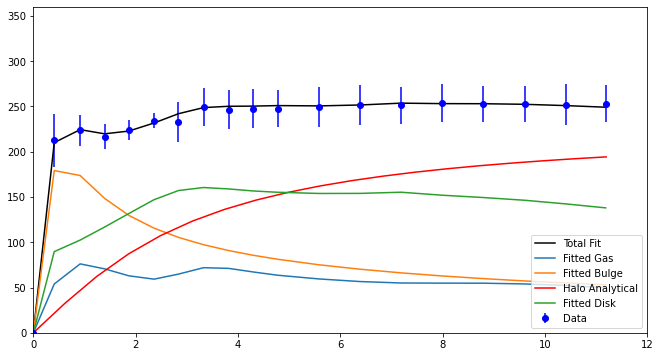

In [8]:
# Define for plotting cont.

#rval = np.linspace(0,11.2,0.1)


g_dict = g_fit.best_values
g_g = g_dict['GX']
g_b = g_dict['BX']
g_d = g_dict['DX']
g_rc = g_dict['rc']
g_rho00 = g_dict['rho00']
halo_curve = nf.h_v(rval,g_rc,g_rho00)

plt.figure(figsize=(11,6))
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(rval,f_v_T_v(rval),'k',label='Total Fit')
plt.plot(r_dat,bestg,'k',label='Total Fit')
plt.plot(rgasr,g_g*rgasv_fit,label='Fitted Gas') #plot doesn't look right if using rval to graph


plt.plot(rbulger,g_b*rbulgev,label='Fitted Bulge')
#plt.scatter(r_dat,g_b*rbulgev_spline(r_dat),label='Bulge Points') #confusion
plt.plot(rval,halo_curve,'r-',label='Halo Analytical')

halo_curve=halo_curve[:len(halo_curve)-6]
halo_curve=halo_curve[0::6]

plt.plot(rdiskr,g_d*rdiskv,label='Fitted Disk')
#plt.plot(halo_dtr,g_h*halo_dtv,label='Fitted Halo')
#ZZZ=np.append([0],bestg)
#bary=ZZZ-halo_curve
#plt.plot(r_dat_andzero,bary,'m',label='Baryonic (visible) matter')

plt.legend(loc='lower right')
plt.ylim(0,360)
plt.xlim(0,12)
plt.show()

## 12-16-20: Halo is larger and disk is smaller than figure 9 (due to degeneracy?). Bulge is very slightly smaller than figure 9. Gas is pretty spot on


In [9]:
# Define components
def bulge(r,BX):
    return BX*rbulgev_fit(r)

def disk(r,DX):
    return DX*rdiskv_fit(r)

def halo(r,rc,rho00):
    return nf.h_v(r,rc,rho00)

def gas(r,GX):
    return GX*rgasv_fit(r)

def totalcurve(r,GX,BX,DX,rc,rho00):
    return np.sqrt((GX*gas(r))**2 
                   + (BX*bulge(r))**2 
                   + (DX*disk(r))**2
                   + (halo(r,rc,rho00))**2)
    return total

In [10]:
#best fitted prefactor values for each component, to be used as default (initial) values for widget sliders
g_dict = g_fit.best_values
best_GX = g_dict['GX']
best_BX = g_dict['BX']
best_DX = g_dict['DX']
best_rc = g_dict['rc']
best_rho00 = g_dict['rho00']
print(g_rho00)

159807992.7766723


In [11]:
# Define plotting function
def f(GX,BX,DX,rc,rho00):
    
    # Define r
    xmax=11.2 #kpc
    r = np.linspace(0.1,xmax,1000)
    
    # Plot
    plt.figure(figsize=(9,7))
    plt.xlim(0,xmax)
    plt.ylim(0,360)
    
    plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
    plt.plot(r,bulge(r,BX),label=("Bulge"),color='orange')
    plt.plot(r,disk(r,DX),label=("Disk"),color='purple')
    plt.plot(r,halo(r,rc,rho00),label=("Halo"),color='green')
    plt.plot(r,gas(r,GX),label=("Gas"),color='blue')
    plt.plot(r,totalcurve(r,BX,GX,rc,rho00,DX),label=("Total Curve"),color='red')
    plt.fill_between(r,
                     noord.greyb_bottom(r),noord.greyb_top(r),
                     color='#dddddd')
    plt.title("Interactive Rotation Curve - Galaxy: NGC 5533")
    plt.xlabel("Radius (kpc)")
    plt.ylabel("Velocity (km/s)")
    
    # Chi squared and reduced chi squared
    # Residuals
    r = np.linspace(0.1,100,69)
    residuals = v_dat - totalcurve(r_dat,BX,GX,DX,rc,rho00)
    # Determining errors
    errors = np.sqrt(v_err1**2 + noord.band**2) #second term is inclination uncertainty
    # Chi squared
    chisquared = np.sum(residuals**2/errors**2)
    #chisquared = stats.chisquare(v_dat,totalcurve(r,M,bpref,dpref,rc,rho00,gpref))
    reducedchisquared = chisquared * (1/(len(r_dat)-6))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(80,170,r"$\chi^2$: {:.5f}".format(chisquared)+'\n'+r"Reduced: {:.5f}".format(reducedchisquared),bbox=props)
    #plt.text(80,150,,bbox=props)
    
    plt.legend(loc='upper right')
    plt.annotate('Can you get the Reduced $\chi^2$ to zero?',
            xy=(0, 0), xytext=(510, 420),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            size=22, ha='left')
    plt.text(105,300,"In a strictly statistical sense, a Reduced $\chi^2$ of zero", fontsize=13),
    plt.text(105,275,"represents a perfect fit; however, a Reduced $\chi^2$ much", fontsize=13),
    plt.text(105,250,"less than one often indicates that more parameters were", fontsize=13),
    plt.text(105,225,"used than represent the physical system. In this fit,", fontsize=13),
    plt.text(105,200,"the Reduced $\chi^2$ is around 1 due primarily to the", fontsize=13),
    plt.text(105,175,"gas component, which is actually fixed (according", fontsize=13),
    plt.text(105,150,"to the physical characteristics of the Hydrogen gas", fontsize=13),
    plt.text(105,125,"it represents; see our video for more details). Here,", fontsize=13),
    plt.text(105,100,"we allow you to break the laws of nature and scale", fontsize=13),
    plt.text(105,75,"each component as you please. See how 'good' of", fontsize=13),
    plt.text(105,50,"a fit you can get!", fontsize=13)
    plt.annotate('Data source: E. Noordermeer. The rotation curves of flattened Sérsic bulges. MNRAS,385(3):1359–1364, Apr 2008',
            xy=(0, 0), xytext=(0,5),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            size=10, ha='left', va='bottom')
    
    plt.show()

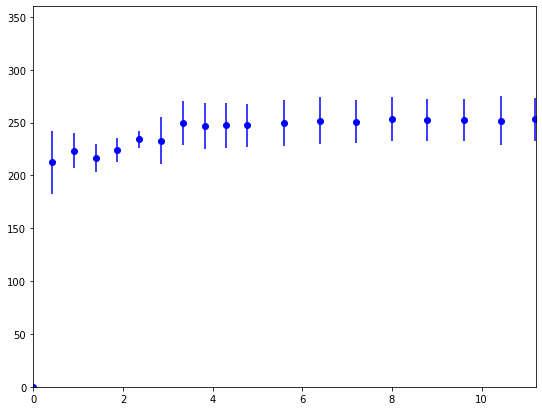

In [12]:
# Appearance
style = {'description_width': 'initial'}
layout = {'width':'600px'}

# Define slides

BX = FloatSlider(min=0, max=5, step=0.1, 
                    value=best_BX, 
                    description='Bulge Prefactor', 
                    readout_format='.2f', 
                    orientation='horizontal', 
                    style=style, layout=layout)

DX = FloatSlider(min=0, max=5, step=0.1, 
                    value=best_DX, 
                    description='Disk Prefactor', 
                    readout_format='.2f', 
                    orientation='horizontal', 
                    style=style, layout=layout)

#rc = FloatSlider(min=0, max=5, step=0.1, value=best_rc, description='Halo Core Radius [kpc]', readout_format='.2f', orientation='horizontal', style=style, layout=layout)
rc = fixed(best_rc)

rho00 = FloatSlider(min=0, max=1e9, step=1e7, 
                    value=best_rho00, 
                    description=r'Halo Surface Density [$M_{\odot} / pc^3$]', 
                    readout_format='.2e', 
                    orientation='horizontal', 
                    style=style, layout=layout)

GX = FloatSlider(min=0, max=5, step=0.1, 
                    value=best_GX, 
                    description='Gas Prefactor', 
                    readout_format='.2f', 
                    orientation='horizontal', 
                    style=style, layout=layout)

# Interactive widget
def interactive_plot(f):
    interact = interactive(f,
                               BX = BX, 
                               DX = DX, 
                               rc = rc,
                               rho00 = rho00,
                               GX = GX,
                               continuous_update=False)
    return interact

# Button to revert back to Best Fit
button = Button(
    description="Best Fit",
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    icon='check')
out = Output()

def on_button_clicked(_):
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    BX.value = best_BX
    DX.value = best_DX
    rho00.value = best_rho00
    GX.value = best_GX

button.on_click(on_button_clicked)

# displaying button and its output together
VBox([button,out,interactive_plot(f)])